In [1]:
import torch
from models.feature_extractor import get_pretrained_model, get_transform
from models.baseline import Baseline
from datasets.download_data import download_data
from datasets.consts import Dataset, DatasetType
from datasets.get_data_loader import get_data_loader
from utils import count_learnable_params, count_non_learnable_params
import time
from utils import divide_into_query_and_support
import wandb
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

/home/lszarejko/.pyenv/versions/few-shot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

way = 5
shot = 5

In [3]:
train_transform, test_transform = get_transform("timm/vit_small_patch16_224.dino")
# train = download_data(Dataset.MINI_IMAGENET, DatasetType.TRAIN, transform=train_transform)
# valid = download_data(Dataset.MINI_IMAGENET, DatasetType.VAL, transform=test_transform)
test = download_data(Dataset.MINI_IMAGENET, DatasetType.TEST, transform=test_transform)

In [4]:
fe = get_pretrained_model("timm/vit_small_patch16_224.dino")
model = Baseline(fe)

learnable_params = count_learnable_params(model.feature_extractor)
non_learnable_params = count_non_learnable_params(model.feature_extractor)
print(f"Learnable parameters: {learnable_params}")
print(f"Non-learnable parameters: {non_learnable_params}")

Learnable parameters: 0
Non-learnable parameters: 21665664


In [5]:
test_loader = get_data_loader(test, way, shot, 15, False)

Average Accuracy:  98.57142857142858 %


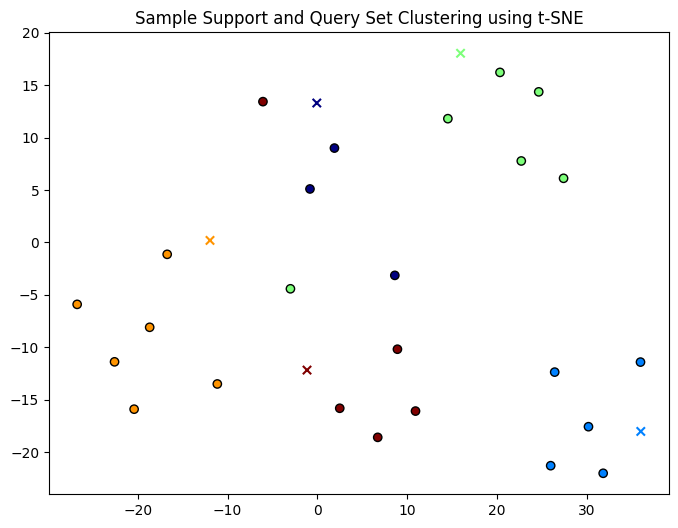

In [ ]:
sum_acc = 0
with torch.no_grad():
    for i, (X, labels) in enumerate(test_loader):
        suppX, queryX, suppY, queryY = divide_into_query_and_support(X, labels, way, shot)
        queryY = queryY.squeeze(0)
        supp_groups, query_groups, supp_features, query_features = model.get_groups_and_features(suppX, queryX, way)
        
        acc = model.calculate_accuracy(query_groups, queryY)
        sum_acc += acc

print("Average Accuracy: ", (sum_acc/i)*100, "%")   
                
all_features = np.vstack((supp_features, query_features))

tsne = TSNE(n_components=2, perplexity=10, random_state=42, max_iter=5000)
reduced_features = tsne.fit_transform(all_features)

supp_reduced = reduced_features[:supp_features.shape[0]]
query_reduced = reduced_features[supp_features.shape[0]:]

plt.figure(figsize=(8, 6))
scatter1 = plt.scatter(supp_reduced[:, 0], supp_reduced[:, 1], c=supp_groups, marker='o', cmap="jet", edgecolors="k", label="Support Set")
scatter2 = plt.scatter(query_reduced[:, 0], query_reduced[:, 1], c=query_groups, marker='x', cmap="jet", label="Query Set")

plt.title("Sample Support and Query Set Clustering using t-SNE")
plt.show()
        
        